# **TR_2021/15 - Technical report: Linear regression to complete Viracopos data**

|Technical Report ID  |2021/15|
|--|--|
| Title |Case crossover for cardiovascular deaths and extreme events|
| Authors | Júlia De Lázari, Paula Dornhofer|
| Creation Date| 2021-08|

Humidity data from the 5 first months of 2017 is missing or inconsistent, so it was discarded. This data was dropped and a linear regression was performed to complete the missing data.

Data from the weather station of CEPAGRI was used to perform this regression.

Based on: https://github.com/climate-and-health-datasci-Unicamp/py-climate-health-toolbox/blob/master/examples/Comparison_IAC_VCP.ipynb

**inputs:** climatic data from viracopos (viracopos.csv) and from cepagri (Cepagri_111_1997_2018.csv)

**outputs:** a new dataframe for viracopos data with the results of the regression for the first 5 months from 2017 (viracopos_regression.csv)

##**Import libraries**

In [ ]:
! git clone https://github.com/climate-and-health-datasci-Unicamp/py-climate-health-toolbox

fatal: destination path 'py-climate-health-toolbox' already exists and is not an empty directory.


In [ ]:
#import python libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import math
import statistics as stat
import scipy.stats as stats
import datetime as dt
import random

#plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
import matplotlib.ticker as mticker

#array 
from array import array
from itertools import repeat

# regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.impute import SimpleImputer

# climatex
import sys
sys.path.append('/content/py-climate-health-toolbox/climahe')
import climatex as tex

#files
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Load data**

In [ ]:
#-------------------------------------------------------------------#
#                          Load Viracopos data                      #
#-------------------------------------------------------------------#

#Load humidity dataframe
df_VCP = pd.read_csv('viracopos.csv')
df_VCP = df_VCP.drop(columns = {'Unnamed: 0'})
df_VCP['DATE'] = pd.to_datetime(df_VCP['DATE']) #convert to datetime
df_VCP['YEAR'] = df_VCP['DATE'].dt.strftime('%Y') #create column for year

#drop inconsistent data
df_VCP.loc[(df_VCP['DATE']>='2016-12-31') & (df_VCP['DATE']<='2017-06-01'), 'HMIN'] = np.nan
df_VCP.loc[(df_VCP['DATE']>='2016-12-31') & (df_VCP['DATE']<='2017-06-01'), 'HMAX'] = np.nan

In [ ]:
#-------------------------------------------------------------------#
#                          Load CEPAGRI data                        #
#-------------------------------------------------------------------#

df_aux = pd.read_csv('Cepagri_111_1997_2018.csv')
df_aux = df_aux[['YEAR','DAY365','HRMINUTE','N_RHMEAN_10']] #keep only needed columns

#create date column using the year and the julian day column
df_aux['DATE'] = pd.to_datetime(df_aux['YEAR'] * 1000 + df_aux['DAY365'], format='%Y%j')
df_aux = df_aux[['DATE','N_RHMEAN_10']]

#drop columns with unacceptable values for humidity (out of the range 0-100%)
df_aux = df_aux[(df_aux['N_RHMEAN_10']>0)&(df_aux['N_RHMEAN_10']<=100)]

#create a second dataframe for minimum and maximum values per day
df_CEPAGRI = pd.DataFrame()
df_CEPAGRI['DATE']=df_aux['DATE']

#get min and maximum per day
df_CEPAGRI['HMAX'] = df_aux.groupby('DATE')['N_RHMEAN_10'].transform(max)
df_CEPAGRI['HMIN'] = df_aux.groupby('DATE')['N_RHMEAN_10'].transform(min)

#drop duplicates
df_CEPAGRI = df_CEPAGRI.drop_duplicates('DATE')

#complete missing dates
df_CEPAGRI = tex.complete_df(df_CEPAGRI)

#create column for year
df_CEPAGRI['YEAR'] = df_CEPAGRI['DATE'].dt.strftime('%Y')
df_CEPAGRI['MONTH'] = df_CEPAGRI['DATE'].dt.strftime('%m')

##**Missing values**

Analyse the percentage of null values of both dataframes. The period of interest is between 2001 and 2018, because of the health data.

In [ ]:
#complete both dataframes using the climatex function
    #this function completes the missing dates and fill the values from this dates with NaN

#CEPAGRI
df_CEPAGRI = tex.complete_df(df_CEPAGRI)

#Viracopos
df_VCP_aux = df_VCP[df_VCP['DATE']>='1997-01-01'] #keep only data after 1997 (start of CEPAGRI data)
df_VCP_aux = tex.complete_df(df_VCP_aux)

In [ ]:
print("Percentage of null values VCP (1983-2018) \n")

print("TMIN:", round((len(df_VCP[df_VCP['TMIN'].isnull()]))/len(df_VCP)*100,2),"%")
print("TMAX:", round((len(df_VCP[df_VCP['TMAX'].isnull()]))/len(df_VCP)*100,2),"%")
print("AVGPRESSURE:", round((len(df_VCP[df_VCP['AVGPRESSURE'].isnull()]))/len(df_VCP)*100,2),"%")
print("HMIN:", round((len(df_VCP[df_VCP['HMIN'].isnull()]))/len(df_VCP)*100,2),"%")
print("HMAX:", round((len(df_VCP[df_VCP['HMAX'].isnull()]))/len(df_VCP)*100,2),"%")

Percentage of null values VCP (1983-2018) 

TMIN: 2.18 %
TMAX: 2.18 %
AVGPRESSURE: 10.66 %
HMIN: 3.32 %
HMAX: 3.32 %


In [ ]:
df_aux = df_VCP[df_VCP['DATE']>='2001-01-01']
print("Percentage of null values VCP (2001-2018) \n")

print("TMIN:", round((len(df_aux[df_aux['TMIN'].isnull()]))/len(df_aux)*100,2),"%")
print("TMAX:", round((len(df_aux[df_aux['TMAX'].isnull()]))/len(df_aux)*100,2),"%")
print("AVGPRESSURE:", round((len(df_aux[df_aux['AVGPRESSURE'].isnull()]))/len(df_aux)*100,2),"%")
print("HMIN:", round((len(df_aux[df_aux['HMIN'].isnull()]))/len(df_aux)*100,2),"%")
print("HMAX:", round((len(df_aux[df_aux['HMAX'].isnull()]))/len(df_aux)*100,2),"%")

Percentage of null values VCP (2001-2018) 

TMIN: 0.17 %
TMAX: 0.17 %
AVGPRESSURE: 0.0 %
HMIN: 2.36 %
HMAX: 2.36 %


In [ ]:
print("Percentage of null values CEPAGRI (1997-2018) \n")

print("HMIN:", round((len(df_CEPAGRI[df_CEPAGRI['HMIN'].isnull()]))/len(df_CEPAGRI)*100,2),"%")
print("HMAX:", round((len(df_CEPAGRI[df_CEPAGRI['HMAX'].isnull()]))/len(df_CEPAGRI)*100,2),"%")

Percentage of null values CEPAGRI (1997-2018) 

HMIN: 1.34 %
HMAX: 1.34 %


In [ ]:
df_aux = df_CEPAGRI[df_CEPAGRI['DATE']>='2001-01-01']
print("Percentage of null values CEPAGRI (2001-2018) \n")

print("HMIN:", round((len(df_aux[df_aux['HMIN'].isnull()]))/len(df_aux)*100,2),"%")
print("HMAX:", round((len(df_aux[df_aux['HMAX'].isnull()]))/len(df_aux)*100,2),"%")

Percentage of null values CEPAGRI (2001-2018) 

HMIN: 0.84 %
HMAX: 0.84 %


##**Plots**

Compare the distribution of data from both dataframes

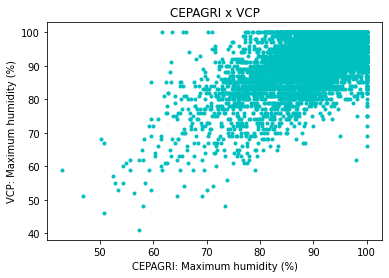

In [ ]:
plt.plot(df_CEPAGRI['HMAX'],df_VCP_aux['HMAX'],'c.')
plt.xlabel('CEPAGRI: Maximum humidity (%)')
plt.ylabel('VCP: Maximum humidity (%)')
plt.title('CEPAGRI x VCP')
plt.show()

Text(0.5, 1.0, 'CEPAGRI x VCP')

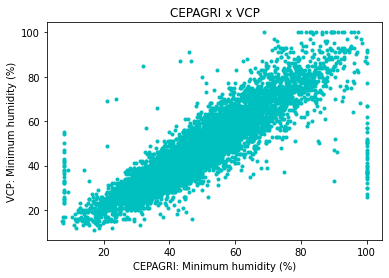

In [ ]:
plt.plot(df_CEPAGRI['HMIN'],df_VCP_aux['HMIN'],'c.')
plt.xlabel('CEPAGRI: Minimum humidity (%)')
plt.ylabel('VCP: Minimum humidity (%)')
plt.title('CEPAGRI x VCP')

##**Regression**

###**Maximum humidity**

In [ ]:
#transforming columns into vector
x_max = df_CEPAGRI['HMAX'].values.reshape(-1,1) 
y_max = df_VCP_aux['HMAX'].values.reshape(-1,1)

In [ ]:
#filling missing data
imputer = SimpleImputer()
x_max_train = imputer.fit_transform(x_max)
y_max_train = imputer.fit_transform(y_max)

In [ ]:
#performing regression
regressor_max = LinearRegression()  
regressor_max.fit(x_max_train, y_max_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#obtaining intercept and slope - relationship between Tmax_IAC and Tmax_VCP
print("Hmax_VCP = Hmax_IAC x",regressor_max.coef_,"+",regressor_max.intercept_)

Hmax_VCP = Hmax_IAC x [[0.59480888]] + [37.94192572]


###**Minimum humidity**

In [ ]:
#transforming columns into vector
x_min = df_CEPAGRI['HMIN'].values.reshape(-1,1) 
y_min = df_VCP_aux['HMIN'].values.reshape(-1,1)

In [ ]:
#filling missing data
imputer = SimpleImputer()
x_min_train = imputer.fit_transform(x_min)
y_min_train = imputer.fit_transform(y_min)

In [ ]:
#performing regression
regressor_min = LinearRegression()  
regressor_min.fit(x_min_train, y_min_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#obtaining intercept and slope - relationship between Tmax_IAC and Tmax_VCP
print("Hmax_VCP = Hmax_IAC x",regressor_min.coef_,"+",regressor_min.intercept_)

Hmax_VCP = Hmax_IAC x [[0.84690863]] + [5.85712938]


##**Use regression to predict 2017 data**

In [ ]:
#CEPAGRI data that will be used to predict Viracopos data
CEPAGRI_base = df_CEPAGRI[(df_CEPAGRI['DATE']>='2016-12-31') & (df_CEPAGRI['DATE']<='2017-06-01')]

###**Maximum humidity**

In [ ]:
#defining predictor CEPAGRI 
Z_max = CEPAGRI_base['HMAX'].values.reshape(-1,1)

#filling missing data
Z_max_imputed = imputer.fit_transform(Z_max)

#predicting Hmax_VCP using regression
hmax_pred=regressor_max.predict(Z_max_imputed)

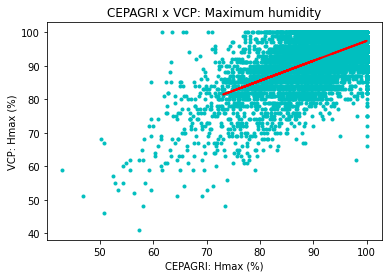

In [ ]:
#Plot of the regression

plt.plot(df_CEPAGRI['HMAX'],df_VCP_aux['HMAX'],'c.')
plt.plot(Z_max, hmax_pred, color='red', linewidth=2)
plt.xlabel('CEPAGRI: Hmax (%)')
plt.ylabel('VCP: Hmax (%)')
plt.title('CEPAGRI x VCP: Maximum humidity')
plt.show()

###**Minimum humidity**

In [ ]:
#defining predictor CEPAGRI 
Z_min = CEPAGRI_base['HMIN'].values.reshape(-1,1)

#filling missing data
Z_min_imputed = imputer.fit_transform(Z_min)

#predicting Hmax_VCP using regression
hmin_pred = regressor_min.predict(Z_min_imputed)

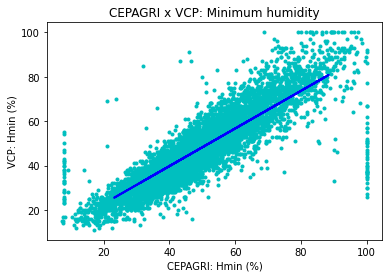

In [ ]:
#Plot of the regression

plt.plot(df_CEPAGRI['HMIN'],df_VCP_aux['HMIN'],'c.')
plt.plot(Z_min, hmin_pred, color='blue', linewidth=2)
plt.xlabel('CEPAGRI: Hmin (%)')
plt.ylabel('VCP: Hmin (%)')
plt.title('CEPAGRI x VCP: Minimum humidity')
plt.show()

##**Reconstruct dataframe**

Include the regression results on the original dataframe

In [ ]:
# fix shape
hmax_pred = np.reshape(hmax_pred,(153,))
hmin_pred = np.reshape(hmin_pred,(153,))

In [ ]:
#replace values in column
df_VCP.HMAX.loc[(df_VCP['DATE']>='2016-12-31') & (df_VCP['DATE']<='2017-06-01')]= hmax_pred
df_VCP.HMIN.loc[(df_VCP['DATE']>='2016-12-31') & (df_VCP['DATE']<='2017-06-01')]= hmin_pred

In [ ]:
#keep only 2 decimal places
df_VCP['HMAX'] = round(df_VCP['HMAX'])
df_VCP['HMIN'] = round(df_VCP['HMIN'])

##**Save new dataframe**

In [ ]:
df_VCP.to_csv('viracopos_regression.csv')